# Market research on small robot-run cafe in Los Angeles

Given research is held for potential investors in a small robot-run cafe in Los Angeles: checking the current market conditions, ability to maintain cafe's success when the novelty of robot waiters wears off and more. The research is based on the open-source data on restaurants in LA.

## Table Of Content:
1. [Openning data & pre-processing](#start)
    - 1.1. [Pre-processing 'address' column](#address)
    - 1.2. [Openning the data](#data)
    - 1.3. [Checking missing values](#null)
    - 1.4. [Conclusion](#start-conc)
    
2. [Data analysis](#analysis)
    - 2.1. [Proportions of the various types of establishments](#establishment1)
    - 2.2. [Proportions of chain and nonchain establishments](#establishment2)
    - 2.3. [Type of establishment as a typical chain](#establishment3)
    - 2.4. [Characteristics of chains: many establishments with a small number of seats or a few establishments with a lot of seats](#establishment4)
    - 2.5. [Average number of seats for each type of restaurant: on average, which type of restaurant has the greatest number of seats](#establishment5)
    - 2.6. [Data on street names from the address column in a separate column](#streets1)
    - 2.7. [Top ten streets by number of restaurants](#streets2)
    - 2.8. [Number of streets that only have one restaurant](#streets3)
    - 2.9. [Trends for streets with a lot of restaurants and the distribution of the number of seats](#streets4)
    - 2.10 [Conclusion](#analysis-conc)
3. [Preparing a presentation](#presentation)
    - [Link](#presentation-conc)
4. [General conclusion](#conclusion)

## Step 1. Openning data & pre-processing <a class="anchor" id="start"></a>


In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mt
from math import factorial
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st
from collections import Counter
import seaborn as sns
import warnings
from datetime import date, timedelta
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
import matplotlib.lines as mlines


In [2]:
!pip install usaddress

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#as we deal here with the US addresses, we'll have to import usaddress library
import usaddress

### 1.1 Openning the data<a class="anchor" id="data"></a>

In [4]:
#Let’s read the data from the csv and check what we have there.
#table from the csv file will be saved as rest_data_us:

rest_data = pd.read_csv('/datasets/rest_data_us.csv', sep=',')
rest_data.info()
display(rest_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
id             9651 non-null int64
object_name    9651 non-null object
address        9651 non-null object
chain          9648 non-null object
object_type    9651 non-null object
number         9651 non-null int64
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


### 1.2 Checking missing values<a class="anchor" id="null"></a>

Let's make sure that the data type for each column is correct and that there are no missing values or duplicates.

In [5]:
rest_data[rest_data.isnull().any(axis=1)] 

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


We have 3 missing values in the **chain** column for the following restaurants:
- TAQUERIA LOS 3 CARNALES
- JAMMIN JIMMY'S PIZZA
- THE LEXINGTON THEATER

Thus, let's replace name "JAMMIN JIMMY'S PIZZA" (id 19309) with "JAMMIN JIMMYS PIZZA" to avoid data analysis issues and as these restaurants are not shops instead of null fill 'False'.

In [6]:
rest_data['object_name'].replace({"JAMMIN JIMMY'S PIZZA": "JAMMIN JIMMYS PIZZA"}, inplace=True)
rest_data.query('id == 19309')

,id,object_name,address,chain,object_type,number
7523,19309,JAMMIN JIMMYS PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1


In [7]:
rest_data['chain'].fillna(False, inplace = True) 
rest_data.query('id == 19194')

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,False,Restaurant,14


### 1.3 pre-processing -  'address' column: <a class="anchor" id="address"></a>


In [8]:
#Let's create one small example street that we will test our library

street_example=rest_data.iloc[0]['address']
street_example

'3708 N EAGLE ROCK BLVD'

In [9]:
#let's use .parse() method and pass to it any unstructed address
#the library will split it into components

usaddress.parse(street_example)

[('3708', 'AddressNumber'),
 ('N', 'StreetNamePreDirectional'),
 ('EAGLE', 'StreetName'),
 ('ROCK', 'StreetName'),
 ('BLVD', 'StreetNamePostType')]

In [10]:
#now it's a list of tuples with the component and it's name
#for example, "StreetName"-"Rock" - and turn it into dictionary

raw_address=usaddress.parse(street_example)

#iterate over a list with components - for each component in raw_address save component's name
#as key (i[1]) and component itself as value of the dictionary (i[0])

dict_address={}
for i in raw_address:
    dict_address.update({i[1]:i[0]})

dict_address

{'AddressNumber': '3708',
 'StreetNamePreDirectional': 'N',
 'StreetName': 'ROCK',
 'StreetNamePostType': 'BLVD'}

In [11]:
#now we have a dictionary with our component of the street and we can deconstruct the street
#we want only street name and number

dict_address['StreetNamePreDirectional']+','+dict_address['StreetName']+','+dict_address['AddressNumber']

'N,ROCK,3708'

In [12]:
#let's wrap a function around it to apply to all our rows and 
#include a loop that will check the addresses "without street or number"
#since in some of the dictionaries there is no AddressNumber 

def cleaning_check(raw):
    raw_address=usaddress.parse(raw)
    dict_address={}
    for i in raw_address:
        dict_address.update({i[1]:i[0]})
    #this line below checks for normal case with street and number    
    if 'StreetName' in dict_address.keys() and 'AddressNumber' in dict_address.keys():
        clean_address=dict_address['AddressNumber']+","+str(dict_address['StreetName'])
        return clean_address
    else:
        return 'no street or number'

In [13]:
#let's apply it to random rows and see how it works

rest_data.address.sample(15).apply(cleaning_check)

3327        10924,PICO
790     6554,HOLLYWOOD
7394     3939,FIGUEROA
3771       7950,SUNSET
1995          750,HILL
1374       8171,SUNSET
8508       141,WESTERN
6057          3425,1ST
3626       940,BROXTON
6228     6100,FIGUEROA
8124       934,ANGELES
1116        10616,PICO
2978         1123,VINE
3792      4300,OLYMPIC
7581        10800,PICO
Name: address, dtype: object

In [14]:
#now let's apply it to all data set

rest_data['clean_street_check']=rest_data.address.apply(cleaning_check)


In [15]:
#let's check what streets has no number

rest_data[rest_data['clean_street_check']=='no street or number']

,id,object_name,address,chain,object_type,number,clean_street_check
1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,no street or number
3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,no street or number
7003,18789,D.K. DONUTS,1033 1/2 LOS ANGELES ST,False,Fast Food,8,no street or number
7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,no street or number
7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,no street or number
7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,no street or number
7327,19113,LA NOCHE BUENA,OLVERA ST E8,False,Restaurant,1,no street or number
7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,no street or number
7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,no street or number


In [16]:
#there are 2 streets: 1) Olvera and 2) 1033 1/2 LOS ANGELES ST
#let's see how library handles them
usaddress.parse(rest_data.iloc[1888]['address'])

[('OLVERA', 'PlaceName'), ('ST', 'StateName'), ('E17', 'ZipCode')]

In [17]:
#the library treats Olvera as PlaceName, not street
#so let's update our function

def cleaning_final(raw):
    if raw.startswith('OLVERA'):
        clean_address='OLVERA,Los Angeles,USA'
    elif raw.startswith('1033 1/2 LOS ANGELES'):
        clean_address='1033 1/2 LOS ANGELES ST,Los Angeles,USA'
    else:
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_address=dict_address['AddressNumber']+" "+str(
            dict_address['StreetName'])+str(', Los Angeles,USA')
    return clean_address

rest_data['clean_street_final']=rest_data.address.apply(cleaning_final)
rest_data.sample(10)

,id,object_name,address,chain,object_type,number,clean_street_check,clean_street_final
9461,21247,CHINA CITY,4578 WHITTIER BLVD,False,Restaurant,31,"4578,WHITTIER","4578 WHITTIER, Los Angeles,USA"
9638,21424,WATTS BURGERS,10203 S CENTRAL AVE,False,Fast Food,15,"10203,CENTRAL","10203 CENTRAL, Los Angeles,USA"
3007,14793,CHIPOTLE MEXICAN GRILL,301 N LARCHMONT BLVD,True,Restaurant,72,"301,LARCHMONT","301 LARCHMONT, Los Angeles,USA"
4423,16209,YOSHINOYA #1254,5656 W MANCHESTER AVE,True,Restaurant,5,"5656,MANCHESTER","5656 MANCHESTER, Los Angeles,USA"
3947,15733,USC - ANNENBERG CAFE,3630 S WATT WAY,False,Restaurant,28,"3630,WATT","3630 WATT, Los Angeles,USA"
5574,17360,MASTER CHEF,937 N HILL ST,False,Restaurant,107,"937,HILL","937 HILL, Los Angeles,USA"
2897,14683,EL CHARRO RESTAURANT,1621 W 6TH ST,True,Restaurant,21,"1621,6TH","1621 6TH, Los Angeles,USA"
8827,20613,BOTANAS EL ATORON,4433 S ALAMEDA ST # B5,True,Restaurant,4,"4433,ALAMEDA","4433 ALAMEDA, Los Angeles,USA"
3303,15089,STARBUCKS COFFEE #13286,4430 E YORK BLVD #A,True,Cafe,39,"4430,YORK","4430 YORK, Los Angeles,USA"
4390,16176,MI CASITA,418 E VERNON AVE,False,Restaurant,26,"418,VERNON","418 VERNON, Los Angeles,USA"


### 1.2 Conclusion <a class="anchor" id="start-conc"></a>

In the present research we are working with a data set from the open-source data on restaurants in LA. It was saved as a table: **rest_data**. Its total length is 9651 rows, every row represents one restaurant and its characteristics in columns: object_name — establishment (restaurant's) name; chain — chain establishment (TRUE/FALSE); object_type — establishment type; address — address; number — number of seats.

While checking duplicated values we didn't find anything suspicious at this stage.
While checking missing values we found 3 missing values in the **chain** column for the following restaurants: TAQUERIA LOS 3 CARNALES, JAMMIN JIMMY'S PIZZA, THE LEXINGTON THEATER.
Then we replaced name "JAMMIN JIMMY'S PIZZA" (id 19309) with "JAMMIN JIMMYS PIZZA" to avoid data analysis issues. As these restaurants names were unique, we supposed that they were not chains, thus, null values were replaced by 'False'.

Then we checked **address** column. To work properly with the US addresses, first, we imported usaddress library and then created a function that deconstructed the street so we got street name and number in order to get the clean address saved in the didcated column clean_street_final.

## Step 2. Data analysis <a class="anchor" id="analysis"></a>


### 2.1 Proportions of the various types of establishments (graph)  <a class="anchor" id="establishment1"></a>

In [18]:
rest = rest_data.groupby('object_type').agg({'id':'nunique'}).reset_index()
rest.columns = ['type','rest_count']
rest['rest_part'] = round(
    100 * rest['rest_count'] / rest.rest_count.sum())
rest.sort_values('rest_part', axis=0, ascending=True)


,type,rest_count,rest_part
0,Bakery,283,3.0
1,Bar,292,3.0
4,Pizza,320,3.0
2,Cafe,435,5.0
3,Fast Food,1066,11.0
5,Restaurant,7255,75.0


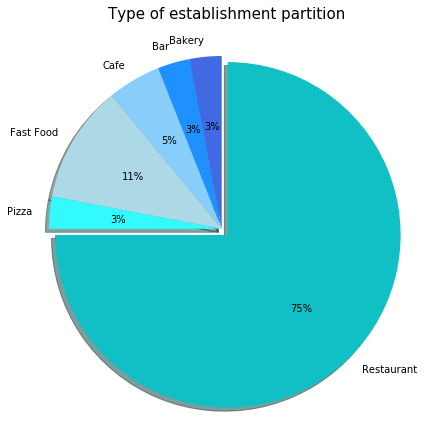

In [19]:
pal = ["royalblue", "dodgerblue", "lightskyblue", "lightblue", "#33faff", "#10c0c4"]

labels = rest.type
sizes = rest.rest_part
explode = (0,0,0,0,0,0.05)  

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.0f%%',
        shadow=True, startangle=90, colors=pal)
ax1.axis('equal')  

plt.title(
    'Type of establishment partition', fontdict={'size':15}
).set_position([.5, 1.05])

plt.show()

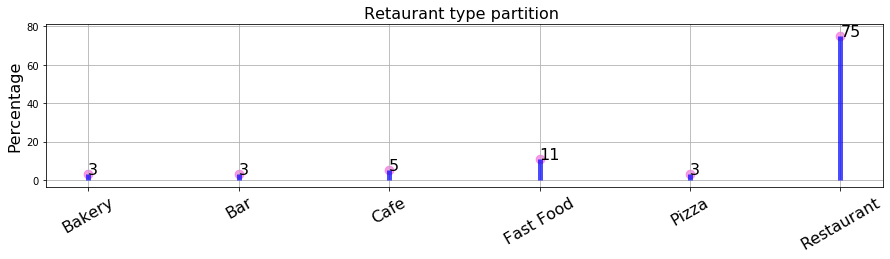

In [20]:
# let's plot chart for absolute retaurant type partition 
fig,ax=plt.subplots(figsize=(15,3))
plt.grid()
ax.vlines(x=rest.type, ymin=0,
          ymax=rest.rest_part, color='blue', alpha=0.7,linewidth=5)
ax.set_title('Retaurant type partition ', fontdict={'size':16})
ax.set_ylabel('Percentage', fontdict={'size':16})
ax.set_xticks(rest.type)
ax.set_xticklabels(rest.type, rotation=30, fontdict={'size':16})

ax.scatter(x=rest.type, y=rest.rest_part, s=75, color='#f573df', alpha=0.7)

for row in rest.itertuples():
    ax.text(row.type, row.rest_part, s=round(row.rest_part), fontdict={'size':16})


We can see that 75% of all establishments are restaurants, pizza, bar and bakeries represent 3% each, 5% of café’s and 11% of fast food.

### 2.2 Proportions of chain and nonchain establishments (graph)<a class="anchor" id="establishment2"></a>

In [21]:
rest_type = rest_data.groupby(['object_type','chain']).agg({'id':'nunique'}).reset_index()
rest_type.columns = ['type','chain','rest_count']
rest_type['rest_part'] = round(
    100 * rest_type['rest_count'] / rest_type.rest_count.sum())

#let's change chain column from True False to Chain Not-chain values

rest_type['chain'] = rest_type['chain'].astype(str).replace({'True':'Chain', 'False':'Not-chain'})
#rest_type

In [22]:
rest_type["type_chain"] = rest_type['type'] +" "+ rest_type['chain'].astype(str)


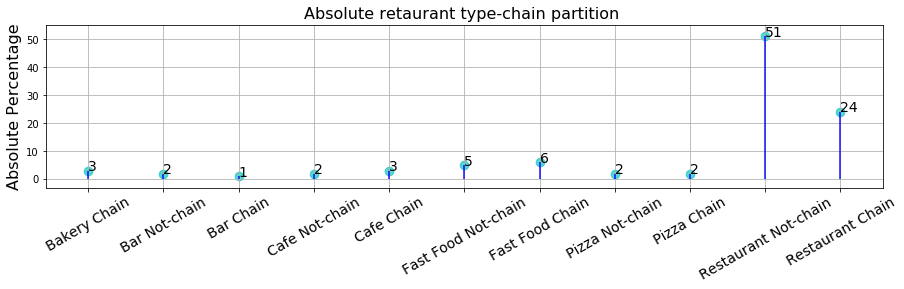

In [23]:
# let's plot chart for absolute retaurant type partition 
fig,ax=plt.subplots(figsize=(15,3))
plt.grid()
ax.vlines(x=rest_type.type_chain, ymin=0,
          ymax=rest_type.rest_part, color='blue', alpha=0.7,linewidth=2)
ax.set_title('Absolute retaurant type-chain partition ', fontdict={'size':16})
ax.set_ylabel('Absolute Percentage', fontdict={'size':16})
ax.set_xticks(rest_type.type_chain)
ax.set_xticklabels(rest_type.type_chain, rotation=30, fontdict={'size':14})

ax.scatter(x=rest_type.type_chain, y=rest_type.rest_part, s=75, color='#10c4c0', alpha=0.7)

for row in rest_type.itertuples():
    ax.text(row.type_chain, row.rest_part, s=round(row.rest_part), fontdict={'size':14})


In [24]:
#let's build a pivot table ti see the graph inside each category - chain vs not chain
pv_rest_type = rest_data.pivot_table(
    index='object_type', columns='chain', values='id', aggfunc='count')
rest_type_t=pv_rest_type.T
rest_type_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, False to True
Data columns (total 6 columns):
Bakery        1 non-null float64
Bar           2 non-null float64
Cafe          2 non-null float64
Fast Food     2 non-null float64
Pizza         2 non-null float64
Restaurant    2 non-null float64
dtypes: float64(6)
memory usage: 112.0+ bytes


object_type,Bakery,Bar,Cafe,Fast Food,Pizza,Restaurant
chain,,,,,,
False,NaN,3.598326,2.828452,7.715481,2.794979,83.062762
True,7.698585,2.094668,7.236126,16.458107,4.162133,62.350381


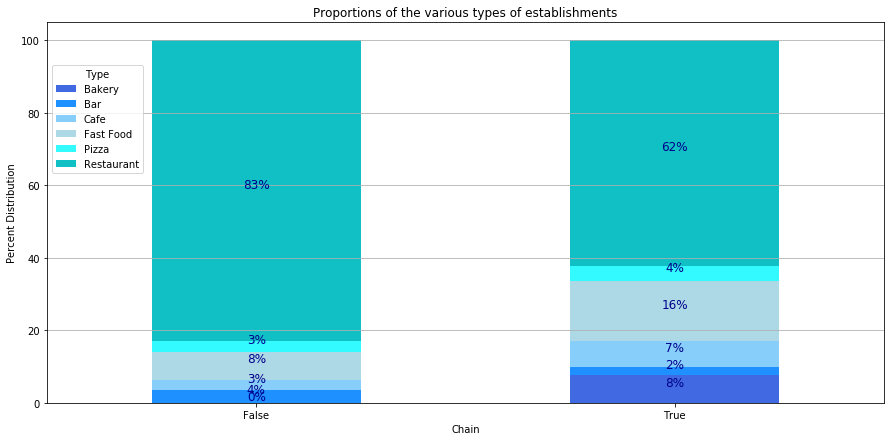

In [25]:
pal = ["royalblue", "dodgerblue", "lightskyblue", "lightblue", "#33faff", "#10c0c4"]

ax=rest_type_t.apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(15,7),stacked=True, rot=0, color=pal)
display(ax)

plt.legend(loc='upper center', bbox_to_anchor=(0.06, 0.9), title="Type")

plt.xlabel('Chain')
plt.ylabel('Percent Distribution')

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              color='darkblue',
              fontsize=12,
              ha='center', 
              va='bottom')
plt.title('Proportions of the various types of establishments')
plt.grid(axis='y')
plt.show()

We can see that the major players among non-chain are restaurants 83% vs chain restaurants 62%. Interesting that there are only chain bakeries in LA (backeries represent 8% among chain establishments).

### 2.3 Type of establishment as a typical chain <a class="anchor" id="establishment3"></a>

In [26]:
chain = rest_type.query('chain == "Chain"')

In [27]:
rest_type

,type,chain,rest_count,rest_part,type_chain
0,Bakery,Chain,283,3.0,Bakery Chain
1,Bar,Not-chain,215,2.0,Bar Not-chain
2,Bar,Chain,77,1.0,Bar Chain
3,Cafe,Not-chain,169,2.0,Cafe Not-chain
4,Cafe,Chain,266,3.0,Cafe Chain
5,Fast Food,Not-chain,461,5.0,Fast Food Not-chain
6,Fast Food,Chain,605,6.0,Fast Food Chain
7,Pizza,Not-chain,167,2.0,Pizza Not-chain
8,Pizza,Chain,153,2.0,Pizza Chain
9,Restaurant,Not-chain,4963,51.0,Restaurant Not-chain


In [28]:
pv_rest_type

chain,False,True
object_type,,
Bakery,NaN,283.0
Bar,215.0,77.0
Cafe,169.0,266.0
Fast Food,461.0,605.0
Pizza,167.0,153.0
Restaurant,4963.0,2292.0


In [29]:
chain['chain_part']=round(100 * chain['rest_count'] / chain.rest_count.sum())
chain

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,type,chain,rest_count,rest_part,type_chain,chain_part
0,Bakery,Chain,283,3.0,Bakery Chain,8.0
2,Bar,Chain,77,1.0,Bar Chain,2.0
4,Cafe,Chain,266,3.0,Cafe Chain,7.0
6,Fast Food,Chain,605,6.0,Fast Food Chain,16.0
8,Pizza,Chain,153,2.0,Pizza Chain,4.0
10,Restaurant,Chain,2292,24.0,Restaurant Chain,62.0


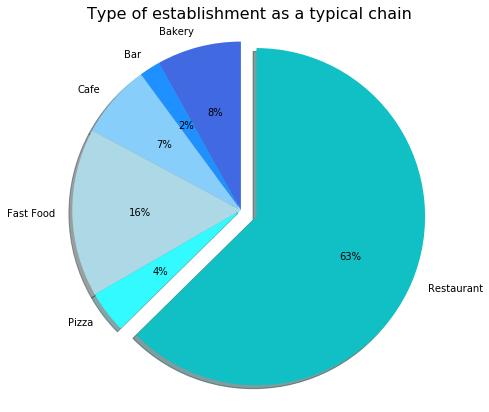

In [30]:
pal = ["royalblue", "dodgerblue", "lightskyblue", "lightblue", "#33faff", "#10c0c4"]

labels = chain.type
sizes = chain.chain_part
explode = (0,0,0,0,0,0.1)  

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90, colors=pal)
ax1.axis('equal')  
plt.title('Type of establishment as a typical chain', fontdict={'size':16})

plt.show()

So, as a typical a chain we can see Restaurants (62%), then fast-food (16%), bakeries (8%) and cafés (7%).


### 2.4 Characteristics of chains: many establishments with a small number of seats or a few establishments with a lot of seats <a class="anchor" id="establishment4"></a>

In [31]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
#rest_data

In [32]:
rest_data.query('chain==True')['number'].max()

229

In [33]:
rest_data.query('chain==True')['number'].describe()

count    3676.000000
mean       39.694233
std        43.437212
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

In [34]:
#let's see - the value_counts will return a count object of number of seats
#and sort_values(ascending=False) will get us the highest values first
rest_data.query('chain==True')['number'].value_counts(
).sort_values(ascending=False).describe()

count    203.000000
mean      18.108374
std       26.401097
min        1.000000
25%        2.000000
50%        5.000000
75%       10.000000
max       99.000000
Name: number, dtype: float64

There are 203 different varieties of number of seats in chain restaurants from 1 as a min to 229 as max number of seats. On average, there are 39 seats. 25% of chain establishments have 13 seats, 50% of them have 25 seats and 75% have 44 seats.

In [35]:
seats_chain=rest_data.query('chain==True')['number']

Text(0.5, 0.98, 'Number of seats among establishments (density)')

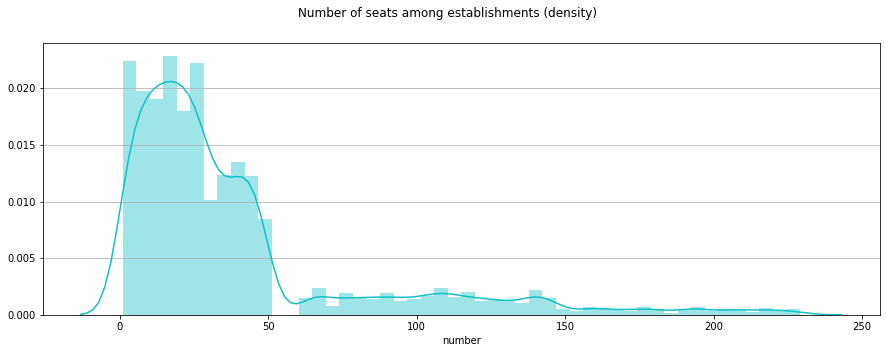

In [36]:
plt.figure(figsize=(15,5))
lst1=seats_chain
plt.grid(axis='y')
sns.distplot(lst1,label='number of seats', color="#10c0c4")
#plt.subplots_adjust(top=0.9)
plt.suptitle('Number of seats among establishments (density)') 


Based on our graph we can confirm, that there are many establishments with a small number of seats (under 50 seats) and fewer establishments with a lot of seats.

### 2.5 Average number of seats for each type of restaurant: on average, which type of restaurant has the greatest number of seats (graphs) <a class="anchor" id="establishment5"></a>

In [37]:
rest_seat = rest_data.groupby('object_type').agg(
    {'id':'nunique','number':'mean'}).reset_index()
rest_seat.columns = ['type','rest_count','avg_seat']
rest_seat=rest_seat.sort_values('avg_seat', axis=0, ascending=False)


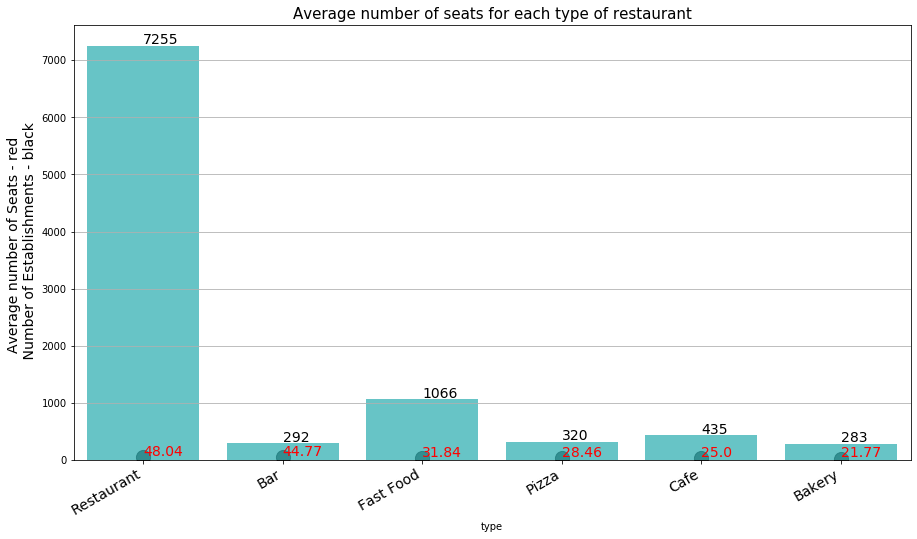

In [38]:
fig,ax=plt.subplots(figsize=(15,8))

ax.scatter(x=rest_seat.type,
           y=rest_seat.avg_seat, 
           s=200, color='black', 
           alpha=0.7)
sns.barplot(x=rest_seat.type, 
            y=rest_seat.rest_count, 
            color='#10c0c4', 
            alpha=0.7)
plt.grid(axis='y')
ax.set_title(
    'Average number of seats for each type of restaurant', fontdict={'size':15})
ax.set_ylabel(
    'Average number of Seats - red \n Number of Establishments - black', fontdict={'size':14})
ax.set_xticks(rest_seat.type)
ax.set_xticklabels(
    rest_seat.type,
    rotation=30,
    fontdict={'horizontalalignment':'right','size':14}
)
for row in rest_seat.itertuples():
    ax.text(
        row.type, row.avg_seat+30, 
        s=round(row.avg_seat, 2), 
        color='red',
        fontdict={'size':14}
    ),
    ax.text(
        row.type, 
        row.rest_count+30, 
        s=round(row.rest_count, 0),
        fontdict={'size':14}
    ) 

We can see that the average number of seats in the restaurant is 48, 47 in the bar, 32 in the fast-food place, 28 in pizza place, 25 in a cafe, and 22 in the bakery.

### 2.6 Data on street names from the address column in a separate column  <a class="anchor" id="streets1"></a>

In [39]:
#let's add column "street_raw" based on our address column 
rest_data['street_number_raw']=rest_data['address']
rest_data[['street_number_raw','street_raw']] = rest_data['street_number_raw'].str.split(n=1,expand=True)
rest_data= rest_data[['id','object_name','chain','object_type','number','clean_street_final','address','street_raw']]
rest_data.head()


,id,object_name,chain,object_type,number,clean_street_final,address,street_raw
0,11786,HABITAT COFFEE SHOP,False,Cafe,26,"3708 ROCK, Los Angeles,USA",3708 N EAGLE ROCK BLVD,N EAGLE ROCK BLVD
1,11787,REILLY'S,False,Restaurant,9,"100 WORLD, Los Angeles,USA",100 WORLD WAY # 120,WORLD WAY # 120
2,11788,STREET CHURROS,False,Fast Food,20,"6801 HOLLYWOOD, Los Angeles,USA",6801 HOLLYWOOD BLVD # 253,HOLLYWOOD BLVD # 253
3,11789,TRINITI ECHO PARK,False,Restaurant,22,"1814 SUNSET, Los Angeles,USA",1814 W SUNSET BLVD,W SUNSET BLVD
4,11790,POLLEN,False,Restaurant,20,"2100 PARK, Los Angeles,USA",2100 ECHO PARK AVE,ECHO PARK AVE


In [40]:
rest_data.street_raw.value_counts().nunique()

74

We found 74 unique street names from the address we had initially.

In [41]:
#now let's add column "street" based on the US address analysis we did earlier

rest_data['street_number']=rest_data['clean_street_final']
rest_data[['street_number','street']] = rest_data['street_number'].str.split(n=1,expand=True)
rest_data[['street','city']] = rest_data['street'].str.split(n=1,expand=True)
rest_data= rest_data[['id','object_name','chain','object_type','number','clean_street_final','address','street','street_raw']]
rest_data.head()

,id,object_name,chain,object_type,number,clean_street_final,address,street,street_raw
0,11786,HABITAT COFFEE SHOP,False,Cafe,26,"3708 ROCK, Los Angeles,USA",3708 N EAGLE ROCK BLVD,"ROCK,",N EAGLE ROCK BLVD
1,11787,REILLY'S,False,Restaurant,9,"100 WORLD, Los Angeles,USA",100 WORLD WAY # 120,"WORLD,",WORLD WAY # 120
2,11788,STREET CHURROS,False,Fast Food,20,"6801 HOLLYWOOD, Los Angeles,USA",6801 HOLLYWOOD BLVD # 253,"HOLLYWOOD,",HOLLYWOOD BLVD # 253
3,11789,TRINITI ECHO PARK,False,Restaurant,22,"1814 SUNSET, Los Angeles,USA",1814 W SUNSET BLVD,"SUNSET,",W SUNSET BLVD
4,11790,POLLEN,False,Restaurant,20,"2100 PARK, Los Angeles,USA",2100 ECHO PARK AVE,"PARK,",ECHO PARK AVE


In [42]:
rest_data.street.value_counts().nunique()

85

There are 85 unique street names based on our US address analysis.

### 2.7 Top ten streets by number of restaurants (graph)  <a class="anchor" id="streets2"></a>

In [43]:
#let'see what streets we have in top 10
rest_street = rest_data.query('object_type=="Restaurant"').groupby(['street']
                               ).agg({'id':'nunique'}
                                    ).reset_index().sort_values(
    by='id', ascending=False)
rest_street.head(10)

,street,id
415,"WILSHIRE,",319
370,"SUNSET,",297
408,"WESTERN,",292
320,"PICO,",283
304,"OLYMPIC,",257
168,"FIGUEROA,",234
387,"VERMONT,",218
20,"3RD,",208
283,"MONICA,",204
214,"HOLLYWOOD,",197


In [44]:
rest_street_raw = rest_data.query('object_type=="Restaurant"').groupby(['street_raw']
                               ).agg({'id':'nunique'}
                                    ).reset_index().sort_values(
    by='id', ascending=False)
rest_street_raw.head(10)
#print((rest_data[rest_data['address'].str.contains('SUNSET')])['street_raw'].value_counts())

,street_raw,id
2133,W PICO BLVD,218
2184,W SUNSET BLVD,217
471,HOLLYWOOD BLVD,136
2302,WILSHIRE BLVD,131
1757,W 3RD ST,119
1550,SANTA MONICA BLVD,107
2058,W OLYMPIC BLVD,107
1379,S VERMONT AVE,107
613,MELROSE AVE,106
125,BEVERLY BLVD,103


In [45]:
rest_street_raw.columns=['street','n_rest']
raw_top10=rest_street_raw.head(10)
raw_top10

,street,n_rest
2133,W PICO BLVD,218
2184,W SUNSET BLVD,217
471,HOLLYWOOD BLVD,136
2302,WILSHIRE BLVD,131
1757,W 3RD ST,119
1550,SANTA MONICA BLVD,107
2058,W OLYMPIC BLVD,107
1379,S VERMONT AVE,107
613,MELROSE AVE,106
125,BEVERLY BLVD,103


In [46]:
rest_street.columns=['street','n_rest']
top10=rest_street.head(10)

In the given contsxt we'll use "street_raw" column as it contains more representative data for our purposes (we can not neglect in this context) street prefex (N,S,W,E etc)

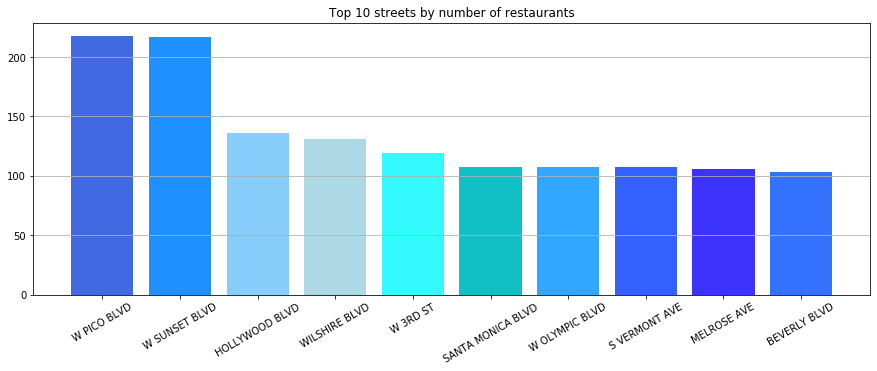

In [47]:
plt.figure(figsize=(15,5))
plt.title('Top 10 streets by number of restaurants')
y_pos = np.arange(len(top10.n_rest))
plt.bar(y_pos, raw_top10.n_rest,
        color=["royalblue", "dodgerblue", "lightskyblue", "lightblue", "#33faff", "#10c0c4", '#33a7ff', '#3361ff', '#3d33ff', '#3372ff'])
plt.xticks(y_pos, raw_top10.street)
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()

We found top 10 streets with number of restaurants that start with 3 boulevard: West Pico, West Sunset and Hollywood with 218, 217 and 136 restaurants respectively.

### 2.8 Number of streets that only have one restaurant  <a class="anchor" id="streets3"></a>

In [48]:
#rest_street.query('n_rest == 1')['street'].value_counts().sort_values()
print(rest_street.query('n_rest == 1')['street'].nunique())

179


We can see that there are at list 179 streets that have only 1 restaurant (note: we neglect in this context street prefix etc.).

### 2.9 Trends for streets with a lot of restaurants and the distribution of the number of seats<a class="anchor" id="streets4"></a>

In [49]:
rest_street_raw_seats = rest_data.query('object_type=="Restaurant"'
                                       ).groupby(['street_raw']
                               ).agg({'id':'nunique', 'number':'mean'}
                                    ).reset_index().sort_values(
    by='id', ascending=False)
rest_street_raw_seats.head(10)

,street_raw,id,number
2133,W PICO BLVD,218,45.215596
2184,W SUNSET BLVD,217,55.705069
471,HOLLYWOOD BLVD,136,58.441176
2302,WILSHIRE BLVD,131,67.068702
1757,W 3RD ST,119,47.655462
1550,SANTA MONICA BLVD,107,35.158879
2058,W OLYMPIC BLVD,107,59.644860
1379,S VERMONT AVE,107,47.841121
613,MELROSE AVE,106,55.216981
125,BEVERLY BLVD,103,51.873786


In [50]:
rest_street_raw_seats.columns=['street','n_rest','avg_seats']
top20=rest_street_raw_seats.head(20)
top20=top20.sort_values(by='avg_seats', ascending=False)
#top20

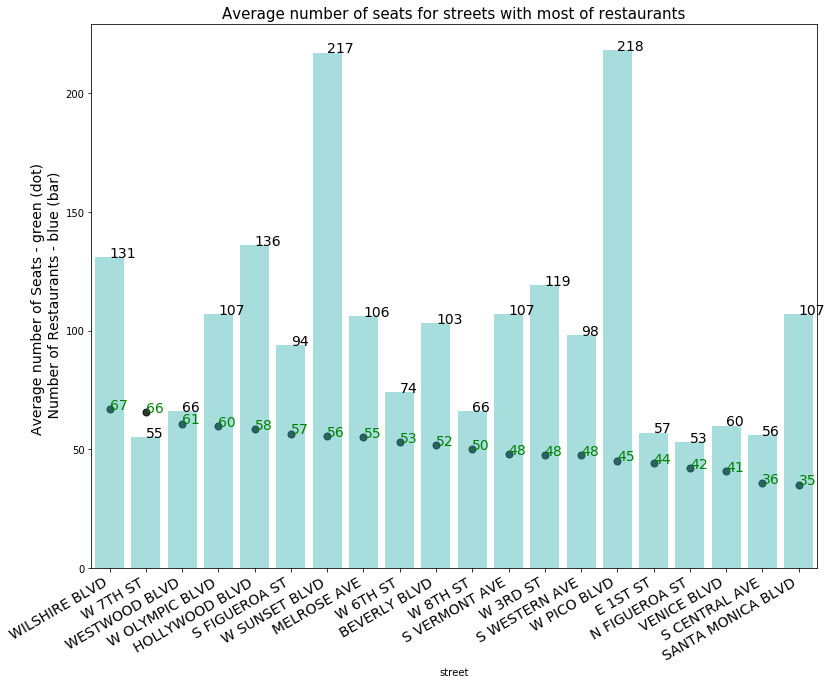

In [51]:
fig,ax=plt.subplots(figsize=(13,10))

ax.scatter(x=top20.street,
           y=top20.avg_seats, 
           s=50, color='black', 
           alpha=0.8)

sns.barplot(x=top20.street, 
            y=top20.n_rest, 
            color='#10c0c4', 
            alpha=0.4)

ax.set_title(
    'Average number of seats for streets with most of restaurants', fontdict={'size':15})
ax.set_ylabel(
    'Average number of Seats - green (dot) \n Number of Restaurants - blue (bar)', fontdict={'size':14})
ax.set_xticks(top20.street)
ax.set_xticklabels(
    top20.street,
    rotation=30,
    fontdict={'horizontalalignment':'right','size':14}
)
for row in top20.itertuples():
    ax.text(
        row.street, row.avg_seats, 
        s=round(row.avg_seats), 
        color='green',
        fontdict={'size':14}
    ),
    ax.text(
        row.street, 
        row.n_rest, 
        s=round(row.n_rest),
        fontdict={'size':14}
    ) 
    

Based on our data we can see that among 20 streets with most of restaurants, the highest average number of seats is on Wilshire boulevards (67), West 7ht street (66) and Westwood boulevard (61). 

### 2.10 Conclusion <a class="anchor" id="analysis-conc"></a>

Following our analysis, we found that 75% of **all establishments** are restaurants; 11% of fast food places; 5% of cafés; pizza places, bars and bakeries represent 3% each.

We can see that the major players among non-chain places are restaurants (83%) vs restaurants 62% within the chain places. Interesting that there are only chain bakeries (no non-chain bakeries at all) in LA, that represent 8% among chain establishments.

As a typical a **chain** we can see Restaurants (62%), then fast-food (16%), bakeries (8%) and cafés (7%).

There are 203 different varieties of **number of seats** in **chain** restaurants from 1 as a min to 229 as max number of seats. On average, there are 39 seats. 25% of chain establishments have 13 seats, 50% of them have 25 seats and 75% have 44 seats.

We saw that there are many establishments with a small **number of seats** (under 50 seats) and fewer establishments with a lot of seats.

We can see that the average number of seats in the restaurant is 48, 47 in the bar, 32 in the fast-food place, 28 in pizza place, 25 in a cafe, and 22 in the bakery.

There are 85 unique **street** names based on our US address analysis and 74 unique street names from the address we had initially (uncleaned).

We found top 10 streets with number of restaurants that start with 3 boulevard: West Pico, West Sunset and Hollywood with 218, 217 and 136 restaurants respectively.

We saw that there are at list 179 streets that have only 1 restaurant (note: we neglect in this context street prefix).

Based on our data we found that among 20 streets with the highest number of restaurants, the highest average number of seats is on Wilshire boulevards (67), West 7ht street (66) and Westwood boulevard (61).

## Step 3. Preparing a presentation <a class="anchor" id="presentation"></a>

### Link <a class="anchor" id="presentation-conc"></a>

https://drive.google.com/file/d/1HK954FviS89xqUkienT5HOKz2bALuh08/view?usp=sharing

## Step 4. General conclusion <a class="anchor" id="conclusion"></a>

In the present research we worked with a data set from the open-source data on restaurants in LA. It was saved as a table: rest_data. Its total length is 9651 rows, every row represents one restaurant and its characteristics in columns: object_name — establishment (restaurant's) name; chain — chain establishment (TRUE/FALSE); object_type — establishment type; address — address; number — number of seats.

While checking duplicated values we didn't find anything suspicious at this stage. While checking missing values we found 3 missing values in the chain column for the following restaurants: TAQUERIA LOS 3 CARNALES, JAMMIN JIMMY'S PIZZA, THE LEXINGTON THEATER. Then we replaced name "JAMMIN JIMMY'S PIZZA" (id 19309) with "JAMMIN JIMMYS PIZZA" to avoid data analysis issues. As these restaurants names were unique, we supposed that they were not chains, thus, null values were replaced by 'False'.

Then we checked address column. To work properly with the US addresses, first, we imported usaddress library and then created a function that deconstructed the street so we got street name and number in order to get the clean address saved in the didcated column clean_street_final.

Following our analysis, we found that 75% of all establishments are restaurants; 11% of fast food places; 5% of cafés; pizza places, bars and bakeries represent 3% each.

We can see that the major players among non-chain places are restaurants (83%) vs restaurants 62% within the chain places. Interesting that there are only chain bakeries (no non-chain bakeries at all) in LA, that represent 8% among chain establishments.

As a typical a chain we can see Restaurants (62%), then fast-food (16%), bakeries (8%) and cafés (7%).

There are 203 different varieties of number of seats in chain restaurants from 1 as a min to 229 as max number of seats. On average, there are 39 seats. 25% of chain establishments have 13 seats, 50% of them have 25 seats and 75% have 44 seats.

We saw that there are many establishments with a small number of seats (under 50 seats) and fewer establishments with a lot of seats.

We can see that the average number of seats in the restaurant is 48, 47 in the bar, 32 in the fast-food place, 28 in pizza place, 25 in a cafe, and 22 in the bakery.

There are 85 unique street names based on our US address analysis and 74 unique street names from the address we had initially (uncleaned).

We found top 10 streets with number of restaurants that start with 3 boulevard: West Pico, West Sunset and Hollywood with 218, 217 and 136 restaurants respectively.

We saw that there are at list 179 streets that have only 1 restaurant (note: we neglect in this context street prefix).

Based on our data we found that among 20 streets with the highest number of restaurants, the highest average number of seats is on Wilshire boulevards (67), West 7ht street (66) and Westwood boulevard (61).

**As a result, based on open source data on almost 10k restaurants, cafes and similar places in LA we found that at list ~180 streets have only one restaurant; top 3 locations for restaurants are boulevards: West Sunset, West Pico and Hollywood. Most of places have 55 seats and there is no non-chain bakeries, but they are still more numerous than cafes - 8% vs 5%.**

**Thus, it is recommended to open a robot-run cafe in one of the top locations: West Sunset or Hollywood boulevard with number of seats between 25 to 30.**